# 資料分析：五個類別的平均 Projection 計算

這個筆記本將處理以下五個類別的資料：
1. **baseline**: creative_baseline.csv + neutral_baseline.csv
2. **multi_prompt** (prompt_cre_env): creative_prompt_cre_env.csv + neutral_prompt_cre_env.csv  
3. **vec_env**: creative_single_env.csv + neutral_single_env.csv
4. **vec_cre**: creative_single_cre.csv + neutral_single_cre.csv
5. **vec_cre_env** (multi): creative_multi.csv + neutral_multi.csv

目標是計算每一層每個類別的平均 projection，並輸出 19-32 層的 CSV 檔案。

In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path

# 設定資料路徑
data_dir = Path('data')
output_dir = Path('analysis_results')
output_dir.mkdir(exist_ok=True)

print("匯入套件完成！")

匯入套件完成！


In [92]:
# 定義五個類別的檔案對應關係
categories = {
    'baseline': {
        'creative': 'creative_baseline.csv',
        'neutral': 'neutral_baseline.csv'
    },
    'multi_prompt': {
        'creative': 'creative_prompt_cre_env.csv',
        'neutral': 'neutral_prompt_cre_env.csv'
    },
    'vec_env': {
        'creative': 'creative_single_env_2.csv',
        'neutral': 'neutral_single_env_2.csv'
    },
    'vec_cre': {
        'creative': 'creative_single_cre_2.csv',
        'neutral': 'neutral_single_cre_2.csv'
    },
    'vec_cre_env': {
        'creative': 'creative_multi_2.csv',
        'neutral': 'neutral_multi_2.csv'
    }
}

print("類別定義完成！")
print(f"總共有 {len(categories)} 個類別")
for cat_name in categories.keys():
    print(f"- {cat_name}")

類別定義完成！
總共有 5 個類別
- baseline
- multi_prompt
- vec_env
- vec_cre
- vec_cre_env


In [93]:
def load_and_combine_category(category_name, file_info):
    """
    載入並合併某個類別的 creative 和 neutral 資料
    計算所有數值欄位的每層平均值並回傳結果
    """
    print(f"\n處理類別: {category_name}")
    
    # 載入 creative 和 neutral 檔案
    creative_path = data_dir / file_info['creative']
    neutral_path = data_dir / file_info['neutral']
    
    print(f"  載入檔案: {creative_path}")
    creative_df = pd.read_csv(creative_path)
    print(f"  載入檔案: {neutral_path}")
    neutral_df = pd.read_csv(neutral_path)
    
    # 確保兩個檔案有相同的結構
    print(f"  Creative 資料形狀: {creative_df.shape}")
    print(f"  Neutral 資料形狀: {neutral_df.shape}")
    print(f"  欄位名稱: {list(creative_df.columns)}")
    
    # 自動識別所有數值型欄位 (排除特定的非數值欄位和 layer)
    # 自動排除文字欄位，只保留數值欄位
    numeric_columns = []
    for col in creative_df.columns:
        if col != 'layer' and creative_df[col].dtype in ['float64', 'int64', 'float32', 'int32']:
            # 排除看起來像索引的欄位
            if col not in ['prompt_idx']:
                numeric_columns.append(col)
    
    print(f"  將計算平均的數值欄位: {numeric_columns}")
    
    # 合併資料並計算平均值
    creative_df['type'] = 'creative'
    neutral_df['type'] = 'neutral'
    
    # 合併資料
    combined_df = pd.concat([creative_df, neutral_df], ignore_index=True)
    
    # 按照 layer 分組並計算平均值，保留其他非數值欄位的第一個值
    # 先取得每層的第一筆資料作為基礎資訊
    first_record = combined_df.groupby('layer').first().reset_index()
    
    # 計算數值欄位的平均值
    avg_numeric = combined_df.groupby('layer')[numeric_columns].mean().reset_index()
    
    # 動態決定要保留的非數值欄位（根據實際存在的欄位）
    text_columns = []
    for col in first_record.columns:
        if col not in numeric_columns and col != 'layer' and col != 'type':
            text_columns.append(col)
    
    keep_columns = ['layer'] + text_columns
    print(f"  保留的基礎資訊欄位: {keep_columns}")
    
    # 取得基礎資訊
    base_info = first_record[keep_columns]
    
    # 合併資料
    avg_df = base_info.merge(avg_numeric, on='layer')
    avg_df['category'] = category_name
    
    print(f"  計算完成，共 {len(avg_df)} 層資料")
    
    return avg_df

In [94]:
for category_name, file_info in categories.items():
    avg_df = load_and_combine_category(category_name, file_info)
    output_path = output_dir / f"{category_name}_avg.csv"
    avg_df.to_csv(output_path, index=False)
    print(f"已儲存 {category_name} 的平均結果至 {output_path}")


處理類別: baseline
  載入檔案: data/creative_baseline.csv
  載入檔案: data/neutral_baseline.csv
  Creative 資料形狀: (130, 11)
  Neutral 資料形狀: (130, 11)
  欄位名稱: ['prompt_idx', 'layer', 'proj_A20', 'proj_B20', 'proj_A_L', 'proj_B_L', 'model', 'vecA_path', 'vecB_path', 'roleA', 'roleB']
  將計算平均的數值欄位: ['proj_A20', 'proj_B20', 'proj_A_L', 'proj_B_L']
  保留的基礎資訊欄位: ['layer', 'prompt_idx', 'model', 'vecA_path', 'vecB_path', 'roleA', 'roleB']
  計算完成，共 13 層資料
已儲存 baseline 的平均結果至 analysis_results/baseline_avg.csv

處理類別: multi_prompt
  載入檔案: data/creative_prompt_cre_env.csv
  載入檔案: data/neutral_prompt_cre_env.csv
  Creative 資料形狀: (130, 11)
  Neutral 資料形狀: (130, 11)
  欄位名稱: ['prompt_idx', 'layer', 'proj_A20', 'proj_B20', 'proj_A_L', 'proj_B_L', 'model', 'vecA_path', 'vecB_path', 'roleA', 'roleB']
  將計算平均的數值欄位: ['proj_A20', 'proj_B20', 'proj_A_L', 'proj_B_L']
  保留的基礎資訊欄位: ['layer', 'prompt_idx', 'model', 'vecA_path', 'vecB_path', 'roleA', 'roleB']
  計算完成，共 13 層資料
已儲存 multi_prompt 的平均結果至 analysis_results/multi_pro

## Analysis Part

In [95]:
# ell 1: setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

sns.set_theme(style="whitegrid")
plt.rcParams["font.sans-serif"] = ["Arial", "DejaVu Sans"]
plt.rcParams["axes.unicode_minus"] = False

# ==== paths (EDIT THESE) ====
DATA_DIR = Path("./analysis_results")

# single-agent (no steering)
FILE_BASELINE      = DATA_DIR / "baseline_avg.csv"
# single-agent with multi role prompt
FILE_MULTI_PROMPT  = DATA_DIR / "multi_prompt_avg.csv"

# vector steering single persona
FILE_VEC_CRE       = DATA_DIR / "vec_cre_avg.csv"    # creative persona steering
FILE_VEC_ENV       = DATA_DIR / "vec_env_avg.csv"    # environmentalist steering

# vector steering merged (cre + env)
FILE_VEC_MERGE     = DATA_DIR / "vec_cre_env_avg.csv"

# ==== small utils ====
def ensure_int(df, col="layer"):
    if col in df.columns:
        df[col] = df[col].astype(int)
    return df

def read_csv(path):
    df = pd.read_csv(path)
    return ensure_int(df, "layer")

def restrict_layers(df, lo=19, hi=32):
    return df[(df["layer"] >= lo) & (df["layer"] <= hi)].copy()

def agg_mean_ci(df, value_col, group_cols=["layer"]):
    """
    Returns mean and 95% CI by group.
    """
    def ci95(x):
        n = x.count()
        if n <= 1:
            return 0.0
        return 1.96 * x.std(ddof=1) / np.sqrt(n)
    g = df.groupby(group_cols)[value_col]
    out = g.agg(mean="mean", ci=ci95).reset_index()
    return out

In [96]:
# Cell 2: load dataframes
df_base   = read_csv(FILE_BASELINE)
df_mprompt= read_csv(FILE_MULTI_PROMPT)

df_cre    = read_csv(FILE_VEC_CRE)
df_env    = read_csv(FILE_VEC_ENV)

df_merge  = read_csv(FILE_VEC_MERGE)

# keep 19–32 only
for name, df in {
    "df_base": df_base, "df_mprompt": df_mprompt,
    "df_cre": df_cre, "df_env": df_env, "df_merge": df_merge
}.items():
    locals()[name] = restrict_layers(df)

# quick schema check (no crash if columns differ a bit)
expected_base_cols   = {"proj_A20","proj_B20","proj_A_L","proj_B_L"}
expected_cre_env_cols= {"proj_v20","proj_vL","proj_transport","delta_l2"}
expected_merge_cols  = {"proj_A20","proj_B20","proj_A_L","proj_B_L",
                        "proj_A_transport","proj_B_transport","delta_l2"}

print("Baseline columns:", sorted(set(df_base.columns)))
print("Multi-prompt columns:", sorted(set(df_mprompt.columns)))
print("vec_cre columns:", sorted(set(df_cre.columns)))
print("vec_env columns:", sorted(set(df_env.columns)))
print("vec_cre_env (merge) columns:", sorted(set(df_merge.columns)))


Baseline columns: ['category', 'layer', 'model', 'proj_A20', 'proj_A_L', 'proj_B20', 'proj_B_L', 'prompt_idx', 'roleA', 'roleB', 'vecA_path', 'vecB_path']
Multi-prompt columns: ['category', 'layer', 'model', 'proj_A20', 'proj_A_L', 'proj_B20', 'proj_B_L', 'prompt_idx', 'roleA', 'roleB', 'vecA_path', 'vecB_path']
vec_cre columns: ['alpha_A', 'alpha_B', 'category', 'delta_l2', 'eps_A', 'eps_B', 'layer', 'model', 'proj_A20', 'proj_A_L', 'proj_A_transport', 'proj_B20', 'proj_B_L', 'proj_B_transport', 'prompt_idx', 'roleA', 'roleB', 'steer_layer', 'vecA_path', 'vecB_path']
vec_env columns: ['alpha_A', 'alpha_B', 'category', 'delta_l2', 'eps_A', 'eps_B', 'layer', 'model', 'proj_A20', 'proj_A_L', 'proj_A_transport', 'proj_B20', 'proj_B_L', 'proj_B_transport', 'prompt_idx', 'roleA', 'roleB', 'steer_layer', 'vecA_path', 'vecB_path']
vec_cre_env (merge) columns: ['alpha_A', 'alpha_B', 'category', 'cos_tA_tB', 'delta_l2', 'eps_A', 'eps_B', 'layer', 'model', 'proj_A20', 'proj_A_L', 'proj_A_transpo

In [97]:
# Cell 0: helpers to annotate line plots every 2 layers

import numpy as np
import matplotlib.pyplot as plt

def annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=9, dy=0.0):
    """
    在 ax 的每條線上，每隔 step 個 x 點標註 y 值。
    - 只處理折線 (Line2D)。對 seaborn lineplot 也適用（其本質是 matplotlib 線）。
    - fmt: 數值格式
    - dy : 垂直位移，避免文字壓到線，可給 0.03*(ymax-ymin) 之類的位移
    """
    lines = [l for l in ax.get_lines() if isinstance(l, plt.Line2D)]
    if not lines:
        return
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin

    for line in lines:
        xdata = line.get_xdata()
        ydata = line.get_ydata()
        # 確保是遞增（seaborn 可能輸出已排序）
        order = np.argsort(xdata)
        xdata = np.asarray(xdata)[order]
        ydata = np.asarray(ydata)[order]
        # 每 step 個點貼一次
        for i in range(0, len(xdata), step):
            x, y = xdata[i], ydata[i]
            if np.isfinite(y):
                ax.text(x, y + dy if dy != 0 else y + 0.03*yspan,
                        fmt.format(y), ha="center", va="bottom",
                        fontsize=fontsize, rotation=0)

def force_axis_labels(ax, xlabel="Layer", ylabel="Value"):
    """保險：強制補上 x/y label。"""
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)


In [180]:
# Cell 0: helpers to annotate line plots every 2 layers - 修改版本

import numpy as np
import matplotlib.pyplot as plt

def annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=9, dy=0.0, 
                             below_series=None):
    """
    在 ax 的每條線上，每隔 step 個 x 點標註 y 值。
    - 只處理折線 (Line2D)。對 seaborn lineplot 也適用（其本質是 matplotlib 線）。
    - fmt: 數值格式
    - dy : 垂直位移，避免文字壓到線，可給 0.03*(ymax-ymin) 之類的位移
    - below_series: 列表，指定哪些系列的標註要放在線條下方
    """
    if below_series is None:
        below_series = ['Prompt CRE + Prompt ENV']
    
    lines = [l for l in ax.get_lines() if isinstance(l, plt.Line2D)]
    if not lines:
        return
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin

    # 取得圖例標籤來識別不同的系列
    legend = ax.get_legend()
    if legend:
        labels = [t.get_text() for t in legend.get_texts()]
    else:
        labels = [f"Series {i}" for i in range(len(lines))]

    for i, line in enumerate(lines):
        xdata = line.get_xdata()
        ydata = line.get_ydata()
        # 確保是遞增（seaborn 可能輸出已排序）
        order = np.argsort(xdata)
        xdata = np.asarray(xdata)[order]
        ydata = np.asarray(ydata)[order]
        
        # 判斷這個系列是否需要標註在下方
        series_label = labels[i] if i < len(labels) else f"Series {i}"
        is_below = any(below_name in series_label for below_name in below_series)
        # is_below = True
        
        # 每 step 個點貼一次
        for j in range(0, len(xdata), step):
            x, y = xdata[j], ydata[j]
            if np.isfinite(y):
                if is_below:
                    # 標註在線條下方
                    offset_y = y - 0.05*yspan if dy == 0.0 else y + dy
                    va = "top"
                else:
                    # 標註在線條上方（預設行為）
                    offset_y = y + 0.03*yspan if dy == 0.0 else y + dy
                    va = "bottom"
                
                ax.text(x, offset_y, fmt.format(y), 
                        ha="center", va=va, fontsize=fontsize, rotation=0)

def force_axis_labels(ax, xlabel="Layer", ylabel="Value"):
    """保險：強制補上 x/y label。"""
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2815546321.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  line_plot = sns.lineplot(data=df_long, x="layer", y="value", hue="method",
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2815546321.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  line_plot = sns.lineplot(data=df_long, x="layer", y="value", hue="method",
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2815546321.py:50: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


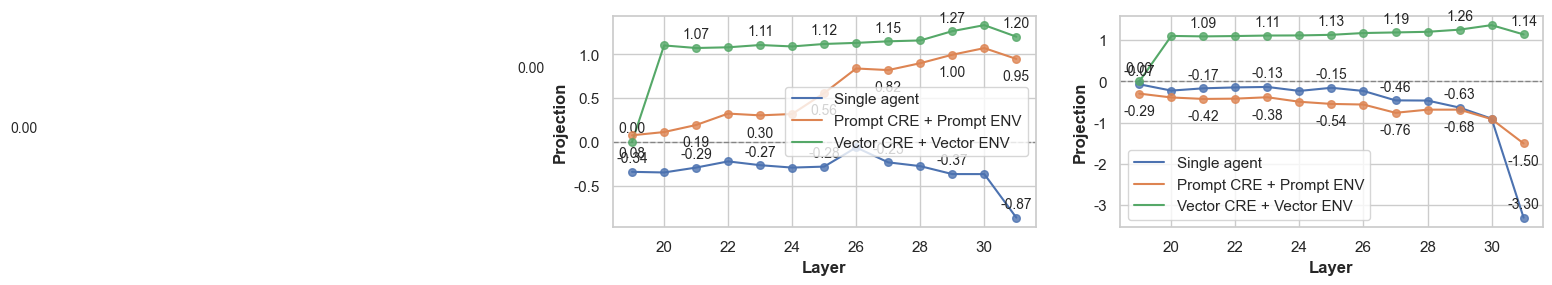

In [196]:
# Cell 3: Fig A1 – Three methods across layers (A-axis & B-axis)

# 建立 long-form 資料框架
# A-axis (creative)
a_single   = df_base[["layer","prompt_idx","proj_A_L"]].assign(method="Single agent")
a_prompt   = df_mprompt[["layer","prompt_idx","proj_A_L"]].assign(method="Prompt CRE + Prompt ENV")
a_steer    = df_merge[["layer","prompt_idx","proj_A_L"]].assign(method="Vector CRE + Vector ENV")

A_long = pd.concat([a_single, a_prompt, a_steer], ignore_index=True).rename(columns={"proj_A_L":"value"})

# B-axis (environmentalist)  
b_single   = df_base[["layer","prompt_idx","proj_B_L"]].assign(method="Single agent")
b_prompt   = df_mprompt[["layer","prompt_idx","proj_B_L"]].assign(method="Prompt CRE + Prompt ENV") 
b_steer    = df_merge[["layer","prompt_idx","proj_B_L"]].assign(method="Vector CRE + Vector ENV")

B_long = pd.concat([b_single, b_prompt, b_steer], ignore_index=True).rename(columns={"proj_B_L":"value"})

# 繪圖
fig, axes = plt.subplots(1, 2, figsize=(12, 2.75), sharey=False)
for ax, df_long, title in zip(
    axes, [A_long, B_long], ["Creative alignment vs layer", "Environmentalist alignment vs layer"]
):
    # 先繪製線條（不含標記點，用於圖例）
    line_plot = sns.lineplot(data=df_long, x="layer", y="value", hue="method",
                            markers=False, ci=95, ax=ax)
    
    # 再繪製資料點（不顯示在圖例中）
    for method in df_long["method"].unique():
        method_data = df_long[df_long["method"] == method]
        # 計算每層的平均值來繪製資料點
        method_means = method_data.groupby("layer")["value"].mean().reset_index()
        # 取得對應的顏色
        color = line_plot.get_lines()[list(df_long["method"].unique()).index(method)].get_color()
        ax.scatter(method_means["layer"], method_means["value"], 
                  color=color, s=30, zorder=5, alpha=0.8)
    
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    # ax.set_title(title)
    ax.set_xlabel("Layer", fontsize=12, fontweight="bold")
    ax.set_ylabel("Projection", fontsize=12, fontweight="bold")
    ax.legend(title="", loc="best")

# fig.suptitle("Baseline vs Multi_Role_Prompt vs Vector Merge – Layer-wise comparison", y=1.02, fontsize=14, fontweight="bold")
# === 每 2 層加入數值標註 + 強制軸標籤 ===
for ax in axes:
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=10)
    # 這張圖 y 軸是投影值
    force_axis_labels(ax, xlabel="Layer", ylabel="Projection")

plt.tight_layout()
plt.show()

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/1800994270.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/1800994270.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/1800994270.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/1800994270.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="laye

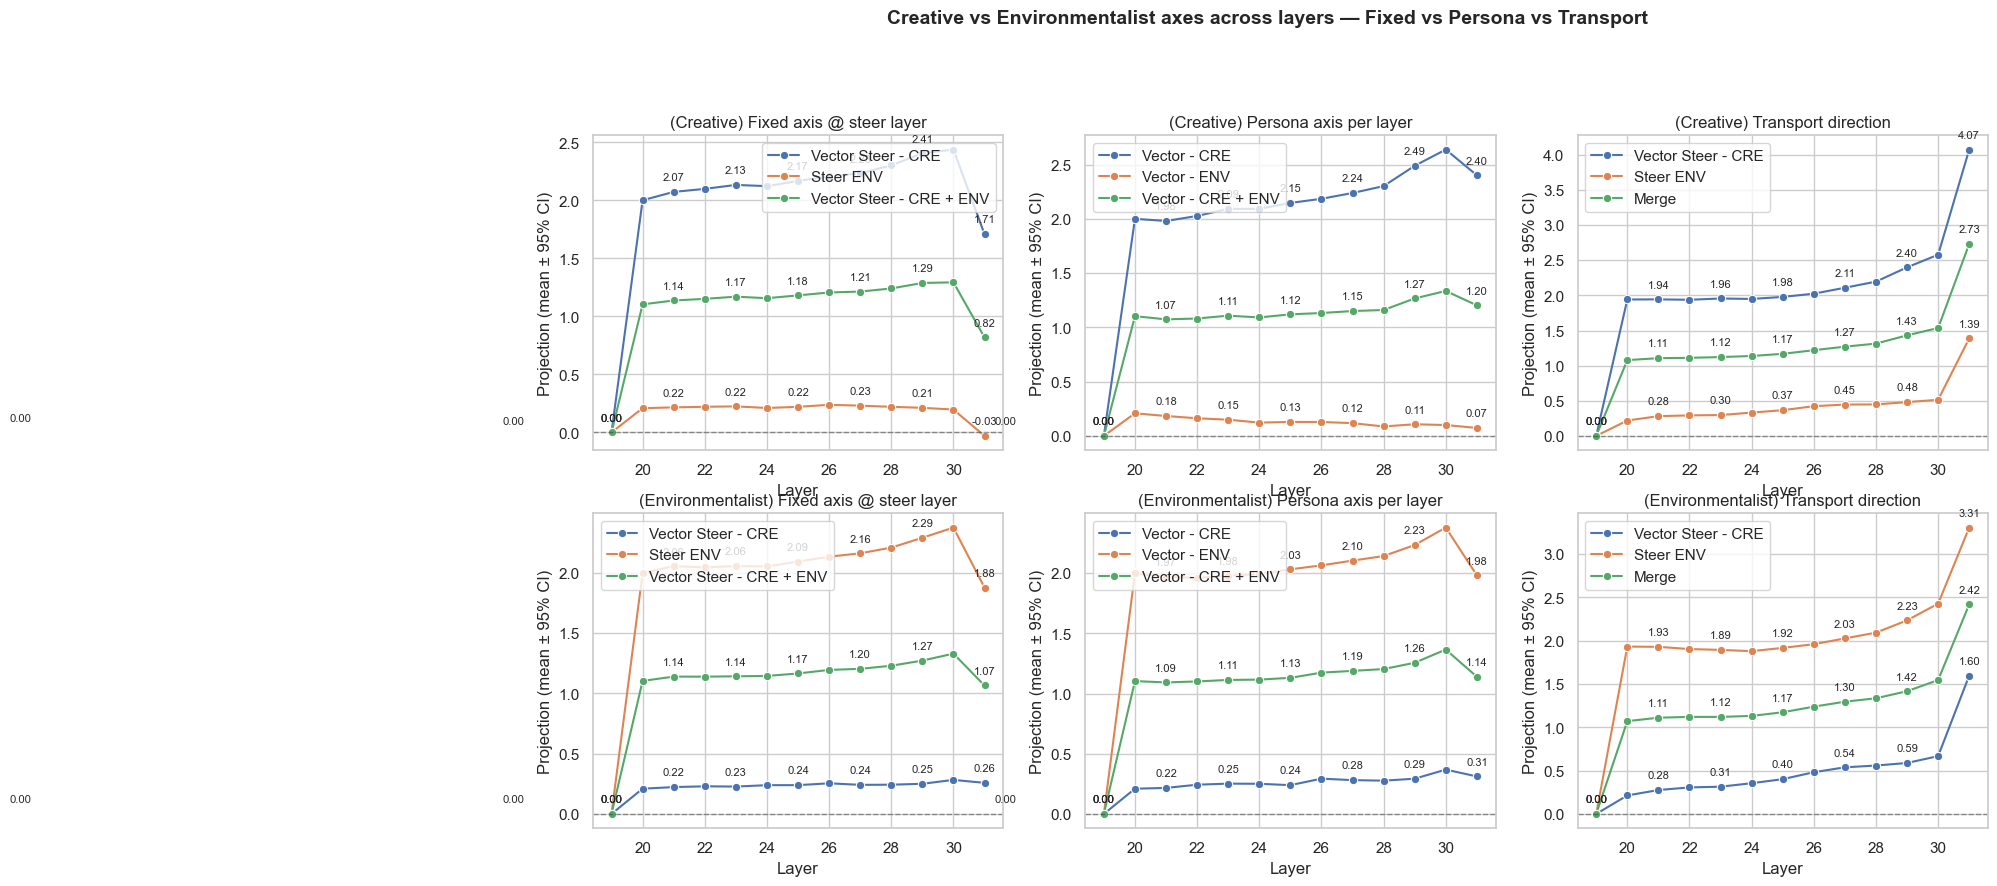

In [118]:
# Cell 4 (six-panels): Creative vs Environmentalist × (Fixed, Persona, Transport)
# expects:
# df_cre: single-axis CRE run
# df_env: single-axis ENV run
# df_merge: merged run (A=CRE, B=ENV)
# helper: agg_mean_ci, annotate_every_two_layers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def col_or_none(df, name):
    return (name in df.columns)

def series_mean_ci(df, col, label):
    out = agg_mean_ci(df, col, ["layer"])
    out["series"] = label
    return out

def build_axis_family(axis, df_cre, df_env, df_merge):
    """
    axis: 'A' (creative) or 'B' (environmentalist)
    return dict with three DataFrames: {'fixed': DF, 'persona': DF, 'transport': DF}
    Each DF has columns: layer, mean, ci, series
    """
    # map merged columns
    m_fixed = f"proj_{axis}20"
    m_persona = f"proj_{axis}_L"
    m_transport = f"proj_{axis}_transport"

    # single-axis fallback columns (own-axis only)
    single_fixed = "proj_v20"
    single_persona = "proj_vL"
    single_transport = "proj_transport"

    # For single CRE run, want creative-axis cols
    # Prefer dual-axis names if present; else fallback to single-axis
    if axis == 'A':
        cre_fixed_col     = "proj_A20" if col_or_none(df_cre, "proj_A20") else (single_fixed if col_or_none(df_cre, single_fixed) else None)
        cre_persona_col   = "proj_A_L" if col_or_none(df_cre, "proj_A_L") else (single_persona if col_or_none(df_cre, single_persona) else None)
        cre_transport_col = "proj_A_transport" if col_or_none(df_cre, "proj_A_transport") else (single_transport if col_or_none(df_cre, single_transport) else None)
        env_fixed_col     = "proj_A20" if col_or_none(df_env, "proj_A20") else (None)  # ENV run measuring A-axis (needs biax CSV)
        env_persona_col   = "proj_A_L" if col_or_none(df_env, "proj_A_L") else (None)
        env_transport_col = "proj_A_transport" if col_or_none(df_env, "proj_A_transport") else (None)
    else:  # axis == 'B'
        cre_fixed_col     = "proj_B20" if col_or_none(df_cre, "proj_B20") else (None)  # CRE run measuring B-axis (needs biax CSV)
        cre_persona_col   = "proj_B_L" if col_or_none(df_cre, "proj_B_L") else (None)
        cre_transport_col = "proj_B_transport" if col_or_none(df_cre, "proj_B_transport") else (None)
        env_fixed_col     = "proj_B20" if col_or_none(df_env, "proj_B20") else (single_fixed if col_or_none(df_env, single_fixed) else None)
        env_persona_col   = "proj_B_L" if col_or_none(df_env, "proj_B_L") else (single_persona if col_or_none(df_env, single_persona) else None)
        env_transport_col = "proj_B_transport" if col_or_none(df_env, "proj_B_transport") else (single_transport if col_or_none(df_env, single_transport) else None)

    out = {}

    # Fixed @ L20
    parts = []
    if cre_fixed_col is not None:
        parts.append(series_mean_ci(df_cre, cre_fixed_col, "Vector Steer - CRE"))
    if env_fixed_col is not None:
        parts.append(series_mean_ci(df_env, env_fixed_col, "Steer ENV"))
    if col_or_none(df_merge, m_fixed):
        parts.append(series_mean_ci(df_merge, m_fixed, "Vector Steer - CRE + ENV"))
    out["fixed"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # Persona-axis per layer
    parts = []
    if cre_persona_col is not None:
        parts.append(series_mean_ci(df_cre, cre_persona_col, "Vector - CRE"))
    if env_persona_col is not None:
        parts.append(series_mean_ci(df_env, env_persona_col, "Vector - ENV"))
    if col_or_none(df_merge, m_persona):
        parts.append(series_mean_ci(df_merge, m_persona, "Vector - CRE + ENV"))
    out["persona"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # Transport
    parts = []
    if cre_transport_col is not None:
        parts.append(series_mean_ci(df_cre, cre_transport_col, "Vector Steer - CRE"))
    if env_transport_col is not None:
        parts.append(series_mean_ci(df_env, env_transport_col, "Steer ENV"))
    if col_or_none(df_merge, m_transport):
        parts.append(series_mean_ci(df_merge, m_transport, "Merge"))
    out["transport"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    return out

# ---- Build data for A (creative) and B (environmentalist) ----
famA = build_axis_family('A', df_cre.copy(), df_env.copy(), df_merge.copy())
famB = build_axis_family('B', df_cre.copy(), df_env.copy(), df_merge.copy())

# ---- Plot 2 rows × 3 cols ----
fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharey=False)
panels = [
    ("(Creative) Fixed axis @ steer layer", famA["fixed"]),
    ("(Creative) Persona axis per layer",   famA["persona"]),
    ("(Creative) Transport direction",      famA["transport"]),
    ("(Environmentalist) Fixed axis @ steer layer", famB["fixed"]),
    ("(Environmentalist) Persona axis per layer",   famB["persona"]),
    ("(Environmentalist) Transport direction",      famB["transport"]),
]

for ax, (title, DF) in zip(axes.flatten(), panels):
    if DF is None or DF.empty:
        ax.set_visible(False)
        continue
    # line + CI
    sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Projection (mean ± 95% CI)")
    ax.legend(title="", loc="best")
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=8)

plt.suptitle("Creative vs Environmentalist axes across layers — Fixed vs Persona vs Transport", 
             y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3630972069.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3630972069.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3630972069.py:29: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


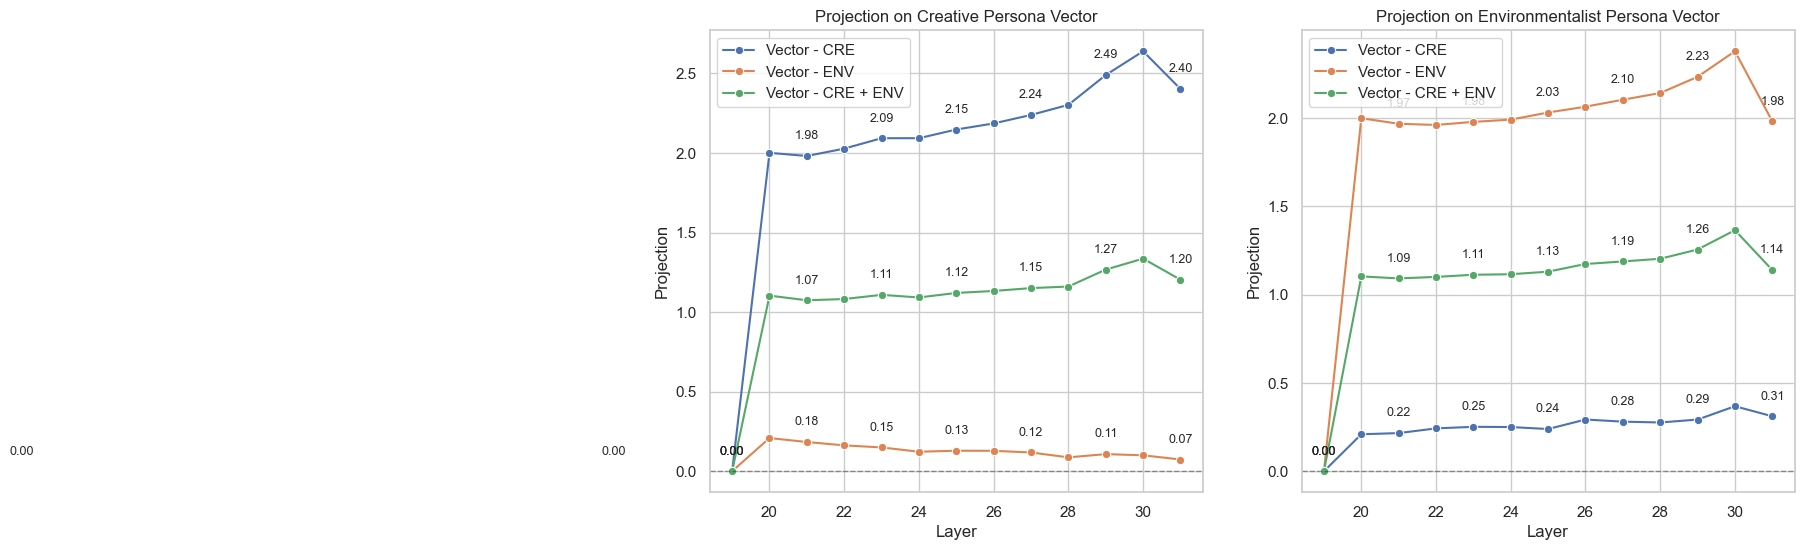

In [119]:
# Cell 4b: Persona axis per layer (Creative vs Environmentalist)

# ---- Plot 2: Persona axis per layer ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

panels_persona = [
    ("Projection on Creative Persona Vector", famA["persona"]),
    ("Projection on Environmentalist Persona Vector", famB["persona"]),
]

for ax, (title, DF) in zip(axes, panels_persona):
    if DF is None or DF.empty:
        ax.set_visible(False)
        continue
    # line + CI
    sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Projection")
    ax.legend(title="", loc="best")
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=9)

# plt.suptitle("Persona axis per layer — Creative vs Environmentalist", 
#              y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2800642131.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  line_plot = sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2800642131.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  line_plot = sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2800642131.py:53: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


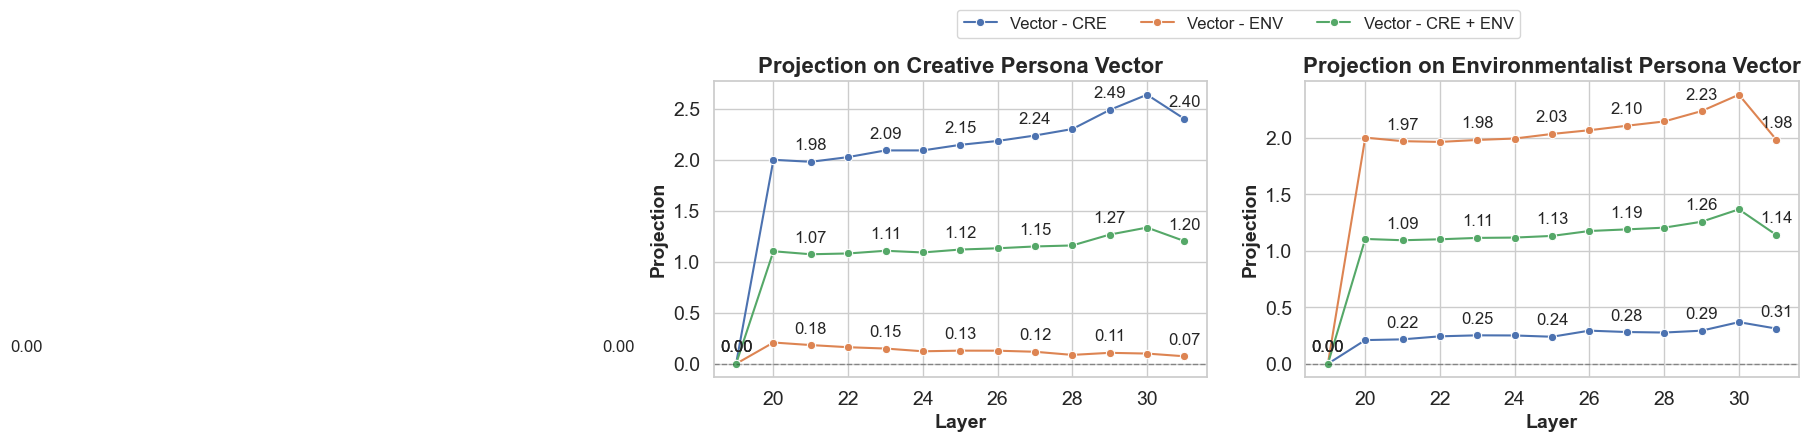

In [133]:
# Cell 4b: Persona axis per layer (Creative vs Environmentalist)

# ---- Plot 2: Persona axis per layer ----
fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=False)

panels_persona = [
    ("Projection on Creative Persona Vector", famA["persona"]),
    ("Projection on Environmentalist Persona Vector", famB["persona"]),
]

# 收集圖例資訊
handles = None
labels = None

for ax, (title, DF) in zip(axes, panels_persona):
    if DF is None or DF.empty:
        ax.set_visible(False)
        continue
    
    # line + CI
    line_plot = sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
    
    # 如果是第一個有效的圖，收集圖例資訊
    if handles is None:
        handles, labels = ax.get_legend_handles_labels()
    
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title, fontsize=16, fontweight='bold')  # 增大標題字體並加粗
    ax.set_xlabel("Layer", fontsize=14, fontweight='bold')  # 增大 x 軸標籤字體並加粗
    ax.set_ylabel("Projection", fontsize=14, fontweight='bold')  # 增大 y 軸標籤字體並加粗

    # 調整刻度標籤字體大小
    ax.tick_params(axis='both', which='major', labelsize=14)
    

    # 移除個別子圖的圖例
    if ax.legend_ is not None:
        ax.legend_.remove()
    
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=12)

# 在整個圖的上方中央建立統一圖例
if handles is not None:
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), 
               ncol=len(labels), frameon=True, fontsize=12)

# 為頂部圖例預留空間
plt.subplots_adjust(top=0.85)
plt.tight_layout()
plt.show()

In [159]:
# Cell 0: helpers to annotate line plots every 2 layers - 修改版本

import numpy as np
import matplotlib.pyplot as plt

def annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=9, dy=0.0, 
                             below_series=None):
    """
    在 ax 的每條線上，每隔 step 個 x 點標註 y 值。
    - 只處理折線 (Line2D)。對 seaborn lineplot 也適用（其本質是 matplotlib 線）。
    - fmt: 數值格式
    - dy : 垂直位移，避免文字壓到線，可給 0.03*(ymax-ymin) 之類的位移
    - below_series: 列表，指定哪些系列的標註要放在線條下方
    """
    if below_series is None:
        below_series = []
    
    lines = [l for l in ax.get_lines() if isinstance(l, plt.Line2D)]
    if not lines:
        return
    ymin, ymax = ax.get_ylim()
    yspan = ymax - ymin

    # 取得圖例標籤來識別不同的系列
    legend = ax.get_legend()
    if legend:
        labels = [t.get_text() for t in legend.get_texts()]
    else:
        labels = [f"Series {i}" for i in range(len(lines))]

    for i, line in enumerate(lines):
        xdata = line.get_xdata()
        ydata = line.get_ydata()
        # 確保是遞增（seaborn 可能輸出已排序）
        order = np.argsort(xdata)
        xdata = np.asarray(xdata)[order]
        ydata = np.asarray(ydata)[order]
        
        # 判斷這個系列是否需要標註在下方
        series_label = labels[i] if i < len(labels) else f"Series {i}"
        # is_below = any(below_name in series_label for below_name in below_series)
        is_below = True
        
        # 每 step 個點貼一次
        for j in range(0, len(xdata), step):
            x, y = xdata[j], ydata[j]
            if np.isfinite(y):
                if is_below:
                    # 標註在線條下方
                    offset_y = y - 0.05*yspan if dy == 0.0 else y + dy
                    va = "top"
                else:
                    # 標註在線條上方（預設行為）
                    offset_y = y + 0.03*yspan if dy == 0.0 else y + dy
                    va = "bottom"
                
                ax.text(x, offset_y, fmt.format(y), 
                        ha="center", va=va, fontsize=fontsize, rotation=0)

def force_axis_labels(ax, xlabel="Layer", ylabel="Value"):
    """保險：強制補上 x/y label。"""
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2628036755.py:39: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=1.0)


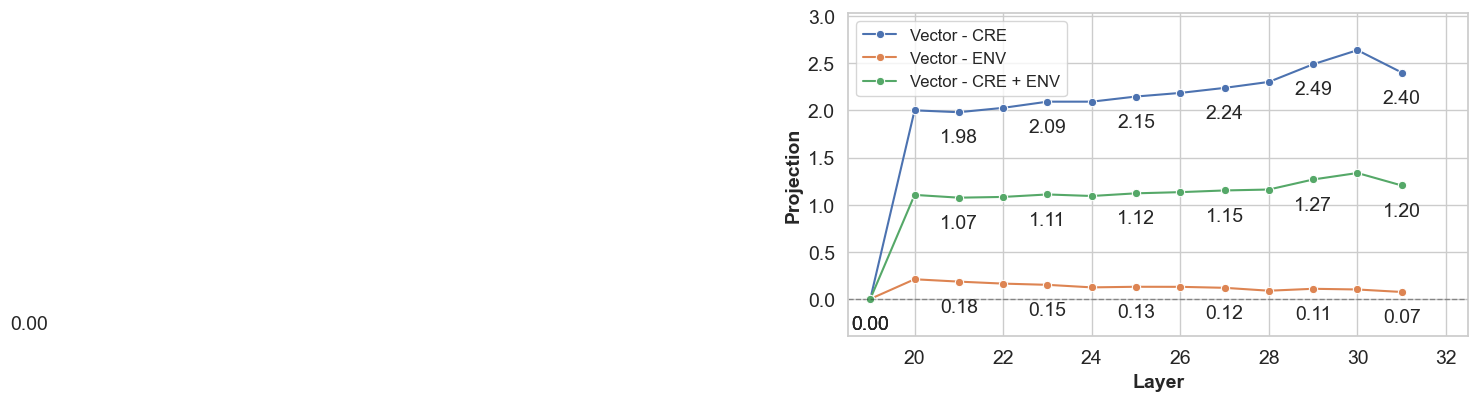

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2628036755.py:78: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(pad=1.0)


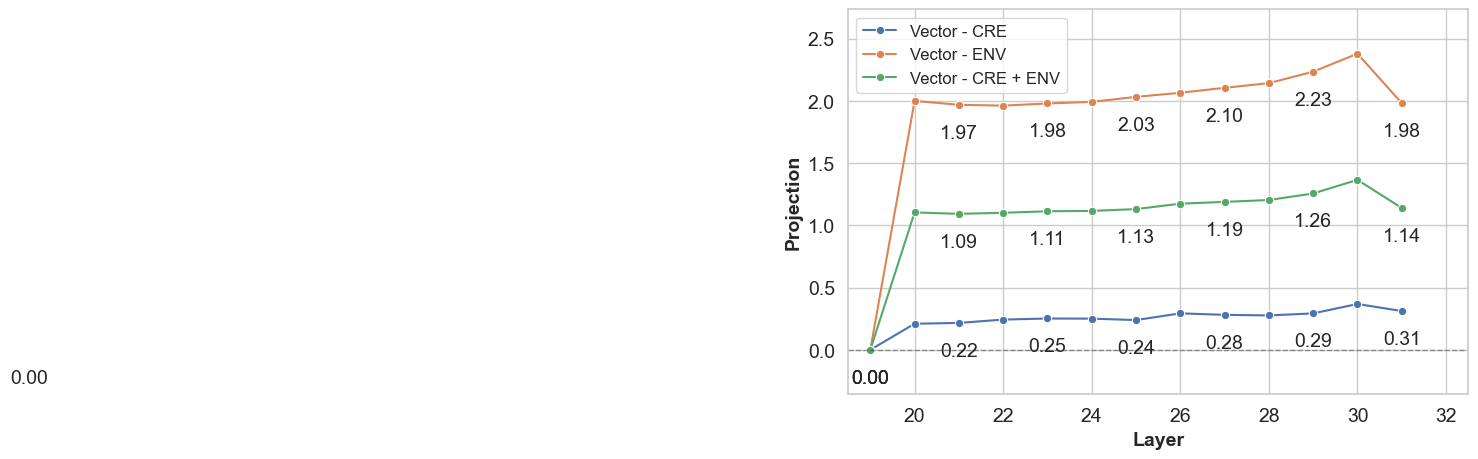

In [167]:
# Cell 4b: Persona axis per layer (Creative vs Environmentalist) - 分開繪製

# ---- 第一張圖：Creative Persona Vector ----
fig, ax = plt.subplots(1, 1, figsize=(8, 4.2))  # 調整圖片大小

title = "Projection on Creative Persona Vector"
DF = famA["persona"]

if DF is not None and not DF.empty:
    # line + CI
    sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", errorbar=None, ax=ax)
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    # ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Layer", fontsize=14, fontweight='bold')
    ax.set_ylabel("Projection", fontsize=14, fontweight='bold')
    
    # 調整刻度標籤字體大小
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # 設定軸的範圍以減少空白
    ax.set_xlim(18.5, 32.5)
    
    # 調整 y 軸範圍
    y_min = DF['mean'].min() - DF['ci'].max()
    y_max = DF['mean'].max() + DF['ci'].max()
    y_padding = (y_max - y_min) * 0.15  # 15% 的邊距，為標註預留空間
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    ax.legend(title="", loc="best", fontsize=12)
    
    # Vector - CRE 系列的標註放在下方
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=14, 
                             below_series=["Vector - CRE"])

plt.tight_layout(pad=1.0)
plt.show()

# ---- 第二張圖：Environmentalist Persona Vector ----
fig, ax = plt.subplots(1, 1, figsize=(8, 5))  # 調整圖片大小

title = "Projection on Environmentalist Persona Vector"
DF = famB["persona"]

if DF is not None and not DF.empty:
    # line + CI
    sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", errorbar=None, ax=ax)
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    # ax.set_title(title, fontsize=16, fontweight='bold')
    ax.set_xlabel("Layer", fontsize=14, fontweight='bold')
    ax.set_ylabel("Projection", fontsize=14, fontweight='bold')
    
    # 調整刻度標籤字體大小
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # 設定軸的範圍以減少空白
    ax.set_xlim(18.5, 32.5)
    
    # 調整 y 軸範圍
    y_min = DF['mean'].min() - DF['ci'].max()
    y_max = DF['mean'].max() + DF['ci'].max()
    y_padding = (y_max - y_min) * 0.15  # 15% 的邊距，為標註預留空間
    ax.set_ylim(y_min - y_padding, y_max + y_padding)
    
    ax.legend(title="", loc="best", fontsize=12)
    
    # Vector - ENV 系列的標註放在下方
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=14, 
                             below_series=["Vector - ENV"])

plt.tight_layout(pad=1.0)
plt.show()

### Figure Set A
- Fig A1 — Compare “three methods” across layers (single agent baseline vs single agent w/ prompt vs merged-vector steering)
- For single/multi-prompt we’ll show persona-axis projections (A_L and B_L).
- For merged steering we’ll show transport projections (A_transport, B_transport).
- Two panels: one for “A axis” signals, one for “B axis” signals.

In [98]:
# # Cell 3: Fig A1 – Three methods across layers (A-axis & B-axis) - 自定義標籤版本

# def custom_annotate_layers(ax, step=2, fmt="{:.2f}", fontsize=8, 
#                           offset_dict=None, skip_points=None):
#     """
#     自定義標籤位置的標註函式
#     - offset_dict: 字典格式 {layer: (dx, dy)} 用於調整特定層的標籤位置
#     - skip_points: 列表格式，跳過標註的層數
#     """
#     if offset_dict is None:
#         offset_dict = {}
#     if skip_points is None:
#         skip_points = []
    
#     lines = [l for l in ax.get_lines() if isinstance(l, plt.Line2D)]
#     if not lines:
#         return
    
#     ymin, ymax = ax.get_ylim()
#     yspan = ymax - ymin
    
#     for line in lines:
#         xdata = line.get_xdata()
#         ydata = line.get_ydata()
#         order = np.argsort(xdata)
#         xdata = np.asarray(xdata)[order]
#         ydata = np.asarray(ydata)[order]
        
#         for i in range(0, len(xdata), step):
#             x, y = xdata[i], ydata[i]
#             if np.isfinite(y) and x not in skip_points:
#                 # 使用自定義偏移或預設偏移
#                 if x in offset_dict:
#                     dx, dy = offset_dict[x]
#                 else:
#                     dx, dy = 0, 0.03*yspan
                
#                 ax.text(x + dx, y + dy, fmt.format(y), 
#                        ha="center", va="bottom", fontsize=fontsize, 
#                        bbox=dict(boxstyle="round,pad=0.2", facecolor="white", 
#                                alpha=0.7, edgecolor="none"))

# # 建立 long-form 資料框架
# # A-axis (creative)
# a_single   = df_base[["layer","prompt_idx","proj_A_L"]].assign(method="Single agent")
# a_prompt   = df_mprompt[["layer","prompt_idx","proj_A_L"]].assign(method="Single+prompt")
# a_steer    = df_merge[["layer","prompt_idx","proj_A_L"]].assign(method="Vector merge")

# A_long = pd.concat([a_single, a_prompt, a_steer], ignore_index=True).rename(columns={"proj_A_L":"value"})

# # B-axis (environmentalist)  
# b_single   = df_base[["layer","prompt_idx","proj_B_L"]].assign(method="Single agent")
# b_prompt   = df_mprompt[["layer","prompt_idx","proj_B_L"]].assign(method="Single+prompt") 
# b_steer    = df_merge[["layer","prompt_idx","proj_B_L"]].assign(method="Vector merge")

# B_long = pd.concat([b_single, b_prompt, b_steer], ignore_index=True).rename(columns={"proj_B_L":"value"})

# # 繪圖
# fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# # 自定義標籤偏移設定（可根據需要調整）
# left_panel_offsets = {
#     20: (0.2, 0.05),   # 第20層標籤稍微右移和上移
#     22: (-0.2, 0.05),  # 第22層標籤稍微左移
#     28: (0, 0.08),     # 第28層標籤上移更多
# }

# right_panel_offsets = {
#     19: (0, 0.1),      # 右圖第19層標籤上移
#     25: (0.2, 0.05),   # 第25層標籤右移
#     31: (-0.2, 0.05),  # 第31層標籤左移
# }

# # 可以選擇跳過某些層的標籤（如果太擁擠）
# skip_layers_left = []  # 例如: [24, 26] 跳過第24和26層
# skip_layers_right = []

# for ax, df_long, title, offsets, skip_layers in zip(
#     axes, 
#     [A_long, B_long], 
#     ["Creative alignment vs layer", "Environmentalist alignment vs layer"],
#     [left_panel_offsets, right_panel_offsets],
#     [skip_layers_left, skip_layers_right]
# ):
#     # 先繪製線條（不含標記點，用於圖例）
#     line_plot = sns.lineplot(data=df_long, x="layer", y="value", hue="method",
#                             markers=False, ci=95, ax=ax)
    
#     # 再繪製資料點（不顯示在圖例中）
#     for method in df_long["method"].unique():
#         method_data = df_long[df_long["method"] == method]
#         method_means = method_data.groupby("layer")["value"].mean().reset_index()
#         color = line_plot.get_lines()[list(df_long["method"].unique()).index(method)].get_color()
#         ax.scatter(method_means["layer"], method_means["value"], 
#                   color=color, s=30, zorder=5, alpha=0.8)
    
#     ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
#     ax.set_title(title)
#     ax.set_xlabel("Layer")
#     ax.set_ylabel("Projection (mean ± 95% CI)")
#     ax.legend(title="", loc="best")
    
#     # 使用自定義標籤函式
#     custom_annotate_layers(ax, step=2, fmt="{:.2f}", fontsize=8, 
#                           offset_dict=offsets, skip_points=skip_layers)

# fig.suptitle("Baseline vs Multi_Role_Prompt vs Vector Merge – Layer-wise comparison", 
#              y=1.02, fontsize=14, fontweight="bold")

# plt.tight_layout()
# plt.show()

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2355266686.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  line_plot = sns.lineplot(data=df_long, x="layer", y="value", hue="method",
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2355266686.py:24: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  line_plot = sns.lineplot(data=df_long, x="layer", y="value", hue="method",
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/2355266686.py:50: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


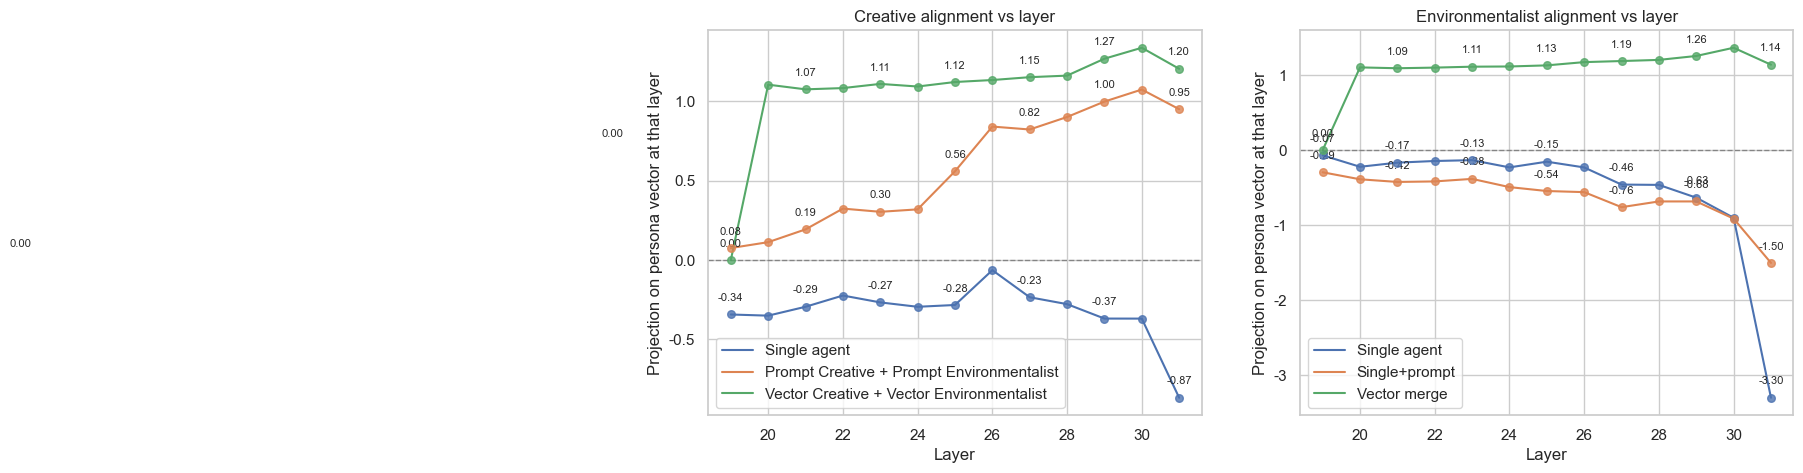

In [99]:
# Cell 3: Fig A1 – Three methods across layers (A-axis & B-axis)

# 建立 long-form 資料框架
# A-axis (creative)
a_single   = df_base[["layer","prompt_idx","proj_A_L"]].assign(method="Single agent")
a_prompt   = df_mprompt[["layer","prompt_idx","proj_A_L"]].assign(method="Prompt Creative + Prompt Environmentalist")
a_steer    = df_merge[["layer","prompt_idx","proj_A_L"]].assign(method="Vector Creative + Vector Environmentalist")

A_long = pd.concat([a_single, a_prompt, a_steer], ignore_index=True).rename(columns={"proj_A_L":"value"})

# B-axis (environmentalist)  
b_single   = df_base[["layer","prompt_idx","proj_B_L"]].assign(method="Single agent")
b_prompt   = df_mprompt[["layer","prompt_idx","proj_B_L"]].assign(method="Single+prompt") 
b_steer    = df_merge[["layer","prompt_idx","proj_B_L"]].assign(method="Vector merge")

B_long = pd.concat([b_single, b_prompt, b_steer], ignore_index=True).rename(columns={"proj_B_L":"value"})

# 繪圖
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)
for ax, df_long, title in zip(
    axes, [A_long, B_long], ["Creative alignment vs layer", "Environmentalist alignment vs layer"]
):
    # 先繪製線條（不含標記點，用於圖例）
    line_plot = sns.lineplot(data=df_long, x="layer", y="value", hue="method",
                            markers=False, ci=95, ax=ax)
    
    # 再繪製資料點（不顯示在圖例中）
    for method in df_long["method"].unique():
        method_data = df_long[df_long["method"] == method]
        # 計算每層的平均值來繪製資料點
        method_means = method_data.groupby("layer")["value"].mean().reset_index()
        # 取得對應的顏色
        color = line_plot.get_lines()[list(df_long["method"].unique()).index(method)].get_color()
        ax.scatter(method_means["layer"], method_means["value"], 
                  color=color, s=30, zorder=5, alpha=0.8)
    
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Projection (mean ± 95% CI)")
    ax.legend(title="", loc="best")

# fig.suptitle("Baseline vs Multi_Role_Prompt vs Vector Merge – Layer-wise comparison", y=1.02, fontsize=14, fontweight="bold")
# === 每 2 層加入數值標註 + 強制軸標籤 ===
for ax in axes:
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=8)
    # 這張圖 y 軸是投影值
    force_axis_labels(ax, xlabel="Layer", ylabel="Projection on persona vector at that layer")

plt.tight_layout()
plt.show()

### Figure Set B
- Fig B1 — Single-persona steering vs merged: layer persona axes
- (show vec_cre proj_vL, vec_env proj_vL, and merged proj_A_L/proj_B_L)

In [71]:
# # Cell 4 (revised): Persona vs Fixed-L20 vs Transport — small multiples

# # expects:
# # - df_cre with columns: ["layer","prompt_idx","proj_v20","proj_vL","proj_transport"]
# # - df_env with columns: ["layer","prompt_idx","proj_v20","proj_vL","proj_transport"]
# # - df_merge with columns:
# #     ["layer","prompt_idx",
# #      "proj_A20","proj_B20",
# #      "proj_A_L","proj_B_L",
# #      "proj_A_transport","proj_B_transport"]

# def _safe_mean_ci(df, col, name):
#     if col not in df.columns:
#         return None
#     out = agg_mean_ci(df, col, ["layer"])
#     out["series"] = name
#     out["metric"] = col
#     return out

# # Build long-form tables for each projection family
# # (A) Fixed axis @ L20
# fixed_parts = []
# p = _safe_mean_ci(df_cre,  "proj_v20",        "Steer CRE: proj(L20)")
# if p is not None: fixed_parts.append(p)
# p = _safe_mean_ci(df_env,  "proj_v20",        "Steer ENV: proj(L20)")
# if p is not None: fixed_parts.append(p)
# p = _safe_mean_ci(df_merge, "proj_A20",       "Merge: proj(A20)")
# if p is not None: fixed_parts.append(p)
# p = _safe_mean_ci(df_merge, "proj_B20",       "Merge: proj(B20)")
# if p is not None: fixed_parts.append(p)
# DF_FIXED = pd.concat(fixed_parts, ignore_index=True) if fixed_parts else None

# # (B) Persona axis per layer
# persona_parts = []
# p = _safe_mean_ci(df_cre,  "proj_vL",         "Steer CRE: proj(v_L)")
# if p is not None: persona_parts.append(p)
# p = _safe_mean_ci(df_env,  "proj_vL",         "Steer ENV: proj(v_L)")
# if p is not None: persona_parts.append(p)
# p = _safe_mean_ci(df_merge, "proj_A_L",       "Merge: proj(A_L)")
# if p is not None: persona_parts.append(p)
# p = _safe_mean_ci(df_merge, "proj_B_L",       "Merge: proj(B_L)")
# if p is not None: persona_parts.append(p)
# DF_PERSONA = pd.concat(persona_parts, ignore_index=True) if persona_parts else None

# # (C) Transport direction
# transport_parts = []
# p = _safe_mean_ci(df_cre,  "proj_transport",  "Steer CRE: proj(transport)")
# if p is not None: transport_parts.append(p)
# p = _safe_mean_ci(df_env,  "proj_transport",  "Steer ENV: proj(transport)")
# if p is not None: transport_parts.append(p)
# p = _safe_mean_ci(df_merge, "proj_A_transport","Merge: proj(A_transport)")
# if p is not None: transport_parts.append(p)
# p = _safe_mean_ci(df_merge, "proj_B_transport","Merge: proj(B_transport)")
# if p is not None: transport_parts.append(p)
# DF_TRANSPORT = pd.concat(transport_parts, ignore_index=True) if transport_parts else None

# # ---- plotting ----
# fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
# panels = [
#     ("(A) Fixed axis @ steer layer", DF_FIXED,     "Projection (mean ± 95% CI)"),
#     ("(B) Persona axis per layer",   DF_PERSONA,   "Projection (mean ± 95% CI)"),
#     ("(C) Transport direction",      DF_TRANSPORT, "Projection (mean ± 95% CI)")
# ]

# for ax, (title, DF, ylabel) in zip(axes, panels):
#     if DF is None or DF.empty:
#         ax.set_visible(False)
#         continue

#     # line(s) with CI fill
#     sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
#     for s in DF["series"].unique():
#         sub = DF[DF["series"] == s]
#         ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)

#     ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
#     ax.set_title(title)
#     ax.set_xlabel("Layer")
#     ax.set_ylabel(ylabel)
#     ax.legend(title="", loc="best")
#     annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=8)

# plt.suptitle("Layer-wise projections: fixed vs persona-axis vs transport (single vs merge)", y=1.03,
#              fontsize=14, fontweight="bold")
# plt.tight_layout()
# plt.show()


/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3950143301.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3950143301.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3950143301.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3950143301.py:110: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="laye

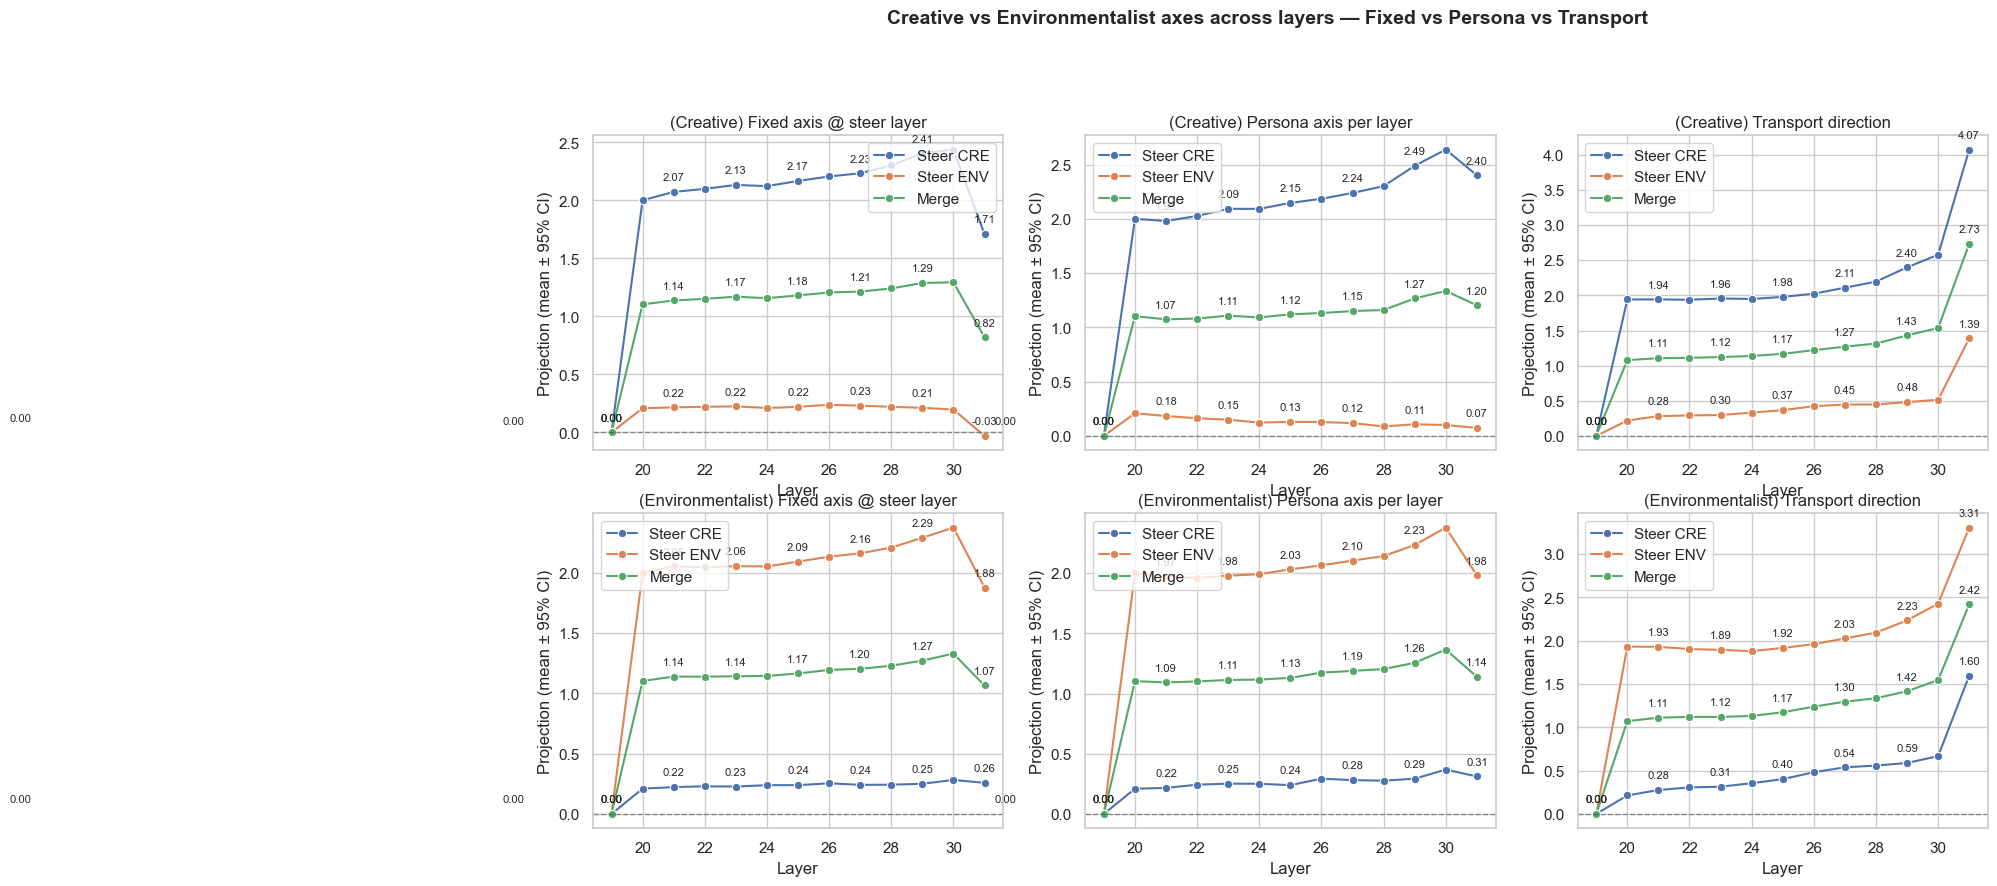

In [102]:
# Cell 4 (six-panels): Creative vs Environmentalist × (Fixed, Persona, Transport)
# expects:
# df_cre: single-axis CRE run
# df_env: single-axis ENV run
# df_merge: merged run (A=CRE, B=ENV)
# helper: agg_mean_ci, annotate_every_two_layers

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def col_or_none(df, name):
    return (name in df.columns)

def series_mean_ci(df, col, label):
    out = agg_mean_ci(df, col, ["layer"])
    out["series"] = label
    return out

def build_axis_family(axis, df_cre, df_env, df_merge):
    """
    axis: 'A' (creative) or 'B' (environmentalist)
    return dict with three DataFrames: {'fixed': DF, 'persona': DF, 'transport': DF}
    Each DF has columns: layer, mean, ci, series
    """
    # map merged columns
    m_fixed = f"proj_{axis}20"
    m_persona = f"proj_{axis}_L"
    m_transport = f"proj_{axis}_transport"

    # single-axis fallback columns (own-axis only)
    single_fixed = "proj_v20"
    single_persona = "proj_vL"
    single_transport = "proj_transport"

    # For single CRE run, want creative-axis cols
    # Prefer dual-axis names if present; else fallback to single-axis
    if axis == 'A':
        cre_fixed_col     = "proj_A20" if col_or_none(df_cre, "proj_A20") else (single_fixed if col_or_none(df_cre, single_fixed) else None)
        cre_persona_col   = "proj_A_L" if col_or_none(df_cre, "proj_A_L") else (single_persona if col_or_none(df_cre, single_persona) else None)
        cre_transport_col = "proj_A_transport" if col_or_none(df_cre, "proj_A_transport") else (single_transport if col_or_none(df_cre, single_transport) else None)
        env_fixed_col     = "proj_A20" if col_or_none(df_env, "proj_A20") else (None)  # ENV run measuring A-axis (needs biax CSV)
        env_persona_col   = "proj_A_L" if col_or_none(df_env, "proj_A_L") else (None)
        env_transport_col = "proj_A_transport" if col_or_none(df_env, "proj_A_transport") else (None)
    else:  # axis == 'B'
        cre_fixed_col     = "proj_B20" if col_or_none(df_cre, "proj_B20") else (None)  # CRE run measuring B-axis (needs biax CSV)
        cre_persona_col   = "proj_B_L" if col_or_none(df_cre, "proj_B_L") else (None)
        cre_transport_col = "proj_B_transport" if col_or_none(df_cre, "proj_B_transport") else (None)
        env_fixed_col     = "proj_B20" if col_or_none(df_env, "proj_B20") else (single_fixed if col_or_none(df_env, single_fixed) else None)
        env_persona_col   = "proj_B_L" if col_or_none(df_env, "proj_B_L") else (single_persona if col_or_none(df_env, single_persona) else None)
        env_transport_col = "proj_B_transport" if col_or_none(df_env, "proj_B_transport") else (single_transport if col_or_none(df_env, single_transport) else None)

    out = {}

    # Fixed @ L20
    parts = []
    if cre_fixed_col is not None:
        parts.append(series_mean_ci(df_cre, cre_fixed_col, "Steer CRE"))
    if env_fixed_col is not None:
        parts.append(series_mean_ci(df_env, env_fixed_col, "Steer ENV"))
    if col_or_none(df_merge, m_fixed):
        parts.append(series_mean_ci(df_merge, m_fixed, "Merge"))
    out["fixed"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # Persona-axis per layer
    parts = []
    if cre_persona_col is not None:
        parts.append(series_mean_ci(df_cre, cre_persona_col, "Steer CRE"))
    if env_persona_col is not None:
        parts.append(series_mean_ci(df_env, env_persona_col, "Steer ENV"))
    if col_or_none(df_merge, m_persona):
        parts.append(series_mean_ci(df_merge, m_persona, "Merge"))
    out["persona"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # Transport
    parts = []
    if cre_transport_col is not None:
        parts.append(series_mean_ci(df_cre, cre_transport_col, "Steer CRE"))
    if env_transport_col is not None:
        parts.append(series_mean_ci(df_env, env_transport_col, "Steer ENV"))
    if col_or_none(df_merge, m_transport):
        parts.append(series_mean_ci(df_merge, m_transport, "Merge"))
    out["transport"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    return out

# ---- Build data for A (creative) and B (environmentalist) ----
famA = build_axis_family('A', df_cre.copy(), df_env.copy(), df_merge.copy())
famB = build_axis_family('B', df_cre.copy(), df_env.copy(), df_merge.copy())

# ---- Plot 2 rows × 3 cols ----
fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharey=False)
panels = [
    ("(Creative) Fixed axis @ steer layer", famA["fixed"]),
    ("(Creative) Persona axis per layer",   famA["persona"]),
    ("(Creative) Transport direction",      famA["transport"]),
    ("(Environmentalist) Fixed axis @ steer layer", famB["fixed"]),
    ("(Environmentalist) Persona axis per layer",   famB["persona"]),
    ("(Environmentalist) Transport direction",      famB["transport"]),
]

for ax, (title, DF) in zip(axes.flatten(), panels):
    if DF is None or DF.empty:
        ax.set_visible(False)
        continue
    # line + CI
    sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Projection (mean ± 95% CI)")
    ax.legend(title="", loc="best")
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=8)

plt.suptitle("Creative vs Environmentalist axes across layers — Fixed vs Persona vs Transport", 
             y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()


/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/415746184.py:102: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/415746184.py:102: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/415746184.py:115: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


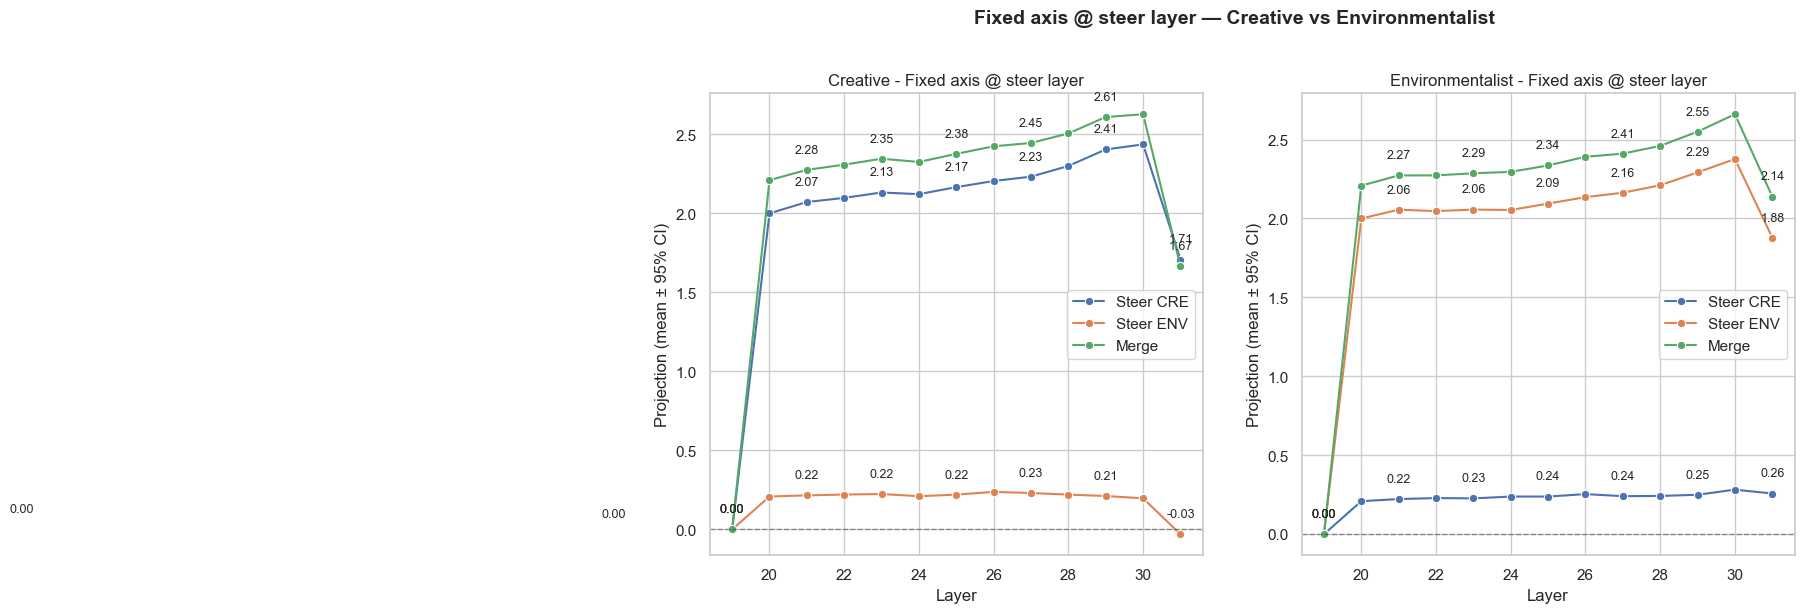

In [66]:
# Cell 4a: Fixed axis @ steer layer (Creative vs Environmentalist)

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def col_or_none(df, name):
    return (name in df.columns)

def series_mean_ci(df, col, label):
    out = agg_mean_ci(df, col, ["layer"])
    out["series"] = label
    return out

def build_axis_family(axis, df_cre, df_env, df_merge):
    """
    axis: 'A' (creative) or 'B' (environmentalist)
    return dict with three DataFrames: {'fixed': DF, 'persona': DF, 'transport': DF}
    Each DF has columns: layer, mean, ci, series
    """
    # map merged columns
    m_fixed = f"proj_{axis}20"
    m_persona = f"proj_{axis}_L"
    m_transport = f"proj_{axis}_transport"

    # single-axis fallback columns (own-axis only)
    single_fixed = "proj_v20"
    single_persona = "proj_vL"
    single_transport = "proj_transport"

    # For single CRE run, want creative-axis cols
    # Prefer dual-axis names if present; else fallback to single-axis
    if axis == 'A':
        cre_fixed_col     = "proj_A20" if col_or_none(df_cre, "proj_A20") else (single_fixed if col_or_none(df_cre, single_fixed) else None)
        cre_persona_col   = "proj_A_L" if col_or_none(df_cre, "proj_A_L") else (single_persona if col_or_none(df_cre, single_persona) else None)
        cre_transport_col = "proj_A_transport" if col_or_none(df_cre, "proj_A_transport") else (single_transport if col_or_none(df_cre, single_transport) else None)
        env_fixed_col     = "proj_A20" if col_or_none(df_env, "proj_A20") else (None)  # ENV run measuring A-axis (needs biax CSV)
        env_persona_col   = "proj_A_L" if col_or_none(df_env, "proj_A_L") else (None)
        env_transport_col = "proj_A_transport" if col_or_none(df_env, "proj_A_transport") else (None)
    else:  # axis == 'B'
        cre_fixed_col     = "proj_B20" if col_or_none(df_cre, "proj_B20") else (None)  # CRE run measuring B-axis (needs biax CSV)
        cre_persona_col   = "proj_B_L" if col_or_none(df_cre, "proj_B_L") else (None)
        cre_transport_col = "proj_B_transport" if col_or_none(df_cre, "proj_B_transport") else (None)
        env_fixed_col     = "proj_B20" if col_or_none(df_env, "proj_B20") else (single_fixed if col_or_none(df_env, single_fixed) else None)
        env_persona_col   = "proj_B_L" if col_or_none(df_env, "proj_B_L") else (single_persona if col_or_none(df_env, single_persona) else None)
        env_transport_col = "proj_B_transport" if col_or_none(df_env, "proj_B_transport") else (single_transport if col_or_none(df_env, single_transport) else None)

    out = {}

    # Fixed @ L20
    parts = []
    if cre_fixed_col is not None:
        parts.append(series_mean_ci(df_cre, cre_fixed_col, "Steer CRE"))
    if env_fixed_col is not None:
        parts.append(series_mean_ci(df_env, env_fixed_col, "Steer ENV"))
    if col_or_none(df_merge, m_fixed):
        parts.append(series_mean_ci(df_merge, m_fixed, "Merge"))
    out["fixed"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # Persona-axis per layer
    parts = []
    if cre_persona_col is not None:
        parts.append(series_mean_ci(df_cre, cre_persona_col, "Steer CRE"))
    if env_persona_col is not None:
        parts.append(series_mean_ci(df_env, env_persona_col, "Steer ENV"))
    if col_or_none(df_merge, m_persona):
        parts.append(series_mean_ci(df_merge, m_persona, "Merge"))
    out["persona"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    # Transport
    parts = []
    if cre_transport_col is not None:
        parts.append(series_mean_ci(df_cre, cre_transport_col, "Steer CRE"))
    if env_transport_col is not None:
        parts.append(series_mean_ci(df_env, env_transport_col, "Steer ENV"))
    if col_or_none(df_merge, m_transport):
        parts.append(series_mean_ci(df_merge, m_transport, "Merge"))
    out["transport"] = pd.concat(parts, ignore_index=True) if parts else pd.DataFrame()

    return out

# ---- Build data for A (creative) and B (environmentalist) ----
famA = build_axis_family('A', df_cre.copy(), df_env.copy(), df_merge.copy())
famB = build_axis_family('B', df_cre.copy(), df_env.copy(), df_merge.copy())

# ---- Plot 1: Fixed axis @ steer layer ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

panels_fixed = [
    ("Creative - Fixed axis @ steer layer", famA["fixed"]),
    ("Environmentalist - Fixed axis @ steer layer", famB["fixed"]),
]

for ax, (title, DF) in zip(axes, panels_fixed):
    if DF is None or DF.empty:
        ax.set_visible(False)
        continue
    # line + CI
    sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Projection (mean ± 95% CI)")
    ax.legend(title="", loc="best")
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=9)

plt.suptitle("Fixed axis @ steer layer — Creative vs Environmentalist", 
             y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3630972069.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3630972069.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3630972069.py:29: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


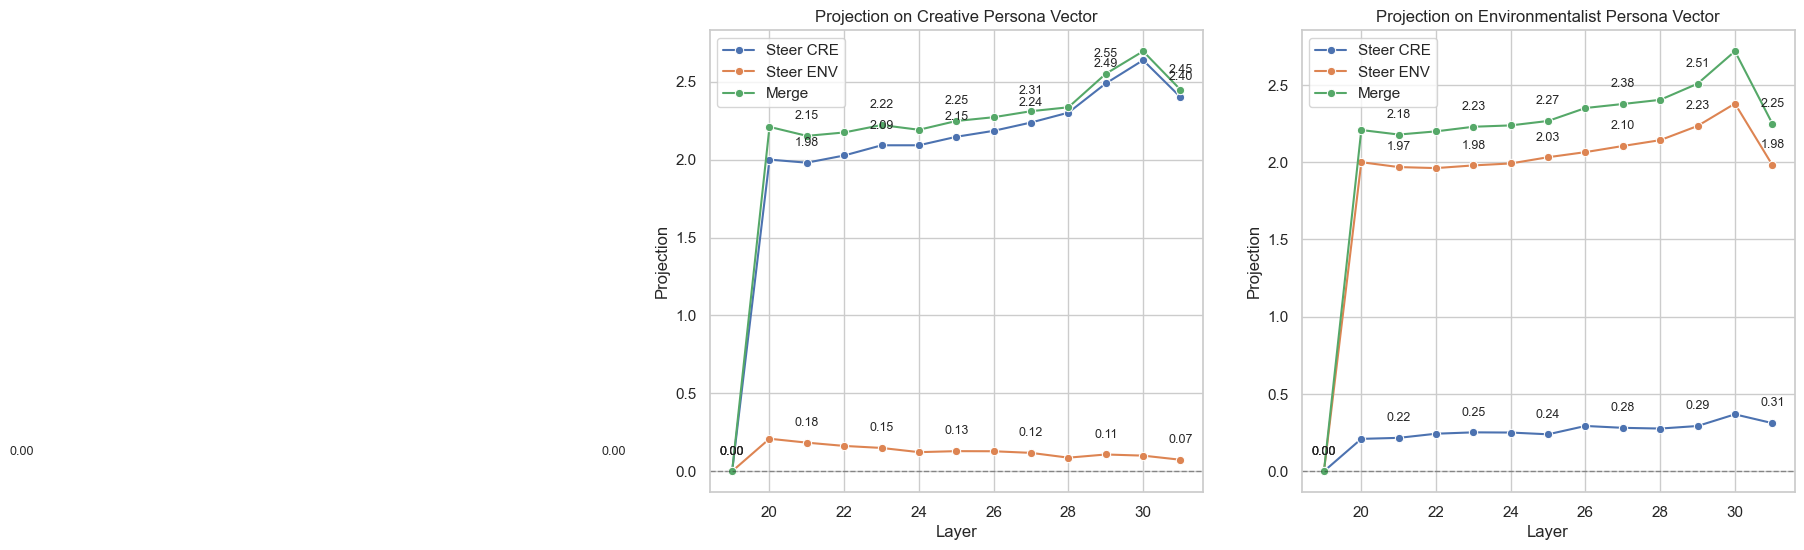

In [80]:
# Cell 4b: Persona axis per layer (Creative vs Environmentalist)

# ---- Plot 2: Persona axis per layer ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

panels_persona = [
    ("Projection on Creative Persona Vector", famA["persona"]),
    ("Projection on Environmentalist Persona Vector", famB["persona"]),
]

for ax, (title, DF) in zip(axes, panels_persona):
    if DF is None or DF.empty:
        ax.set_visible(False)
        continue
    # line + CI
    sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Projection")
    ax.legend(title="", loc="best")
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=9)

# plt.suptitle("Persona axis per layer — Creative vs Environmentalist", 
#              y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3178090043.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3178090043.py:16: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/3178090043.py:29: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


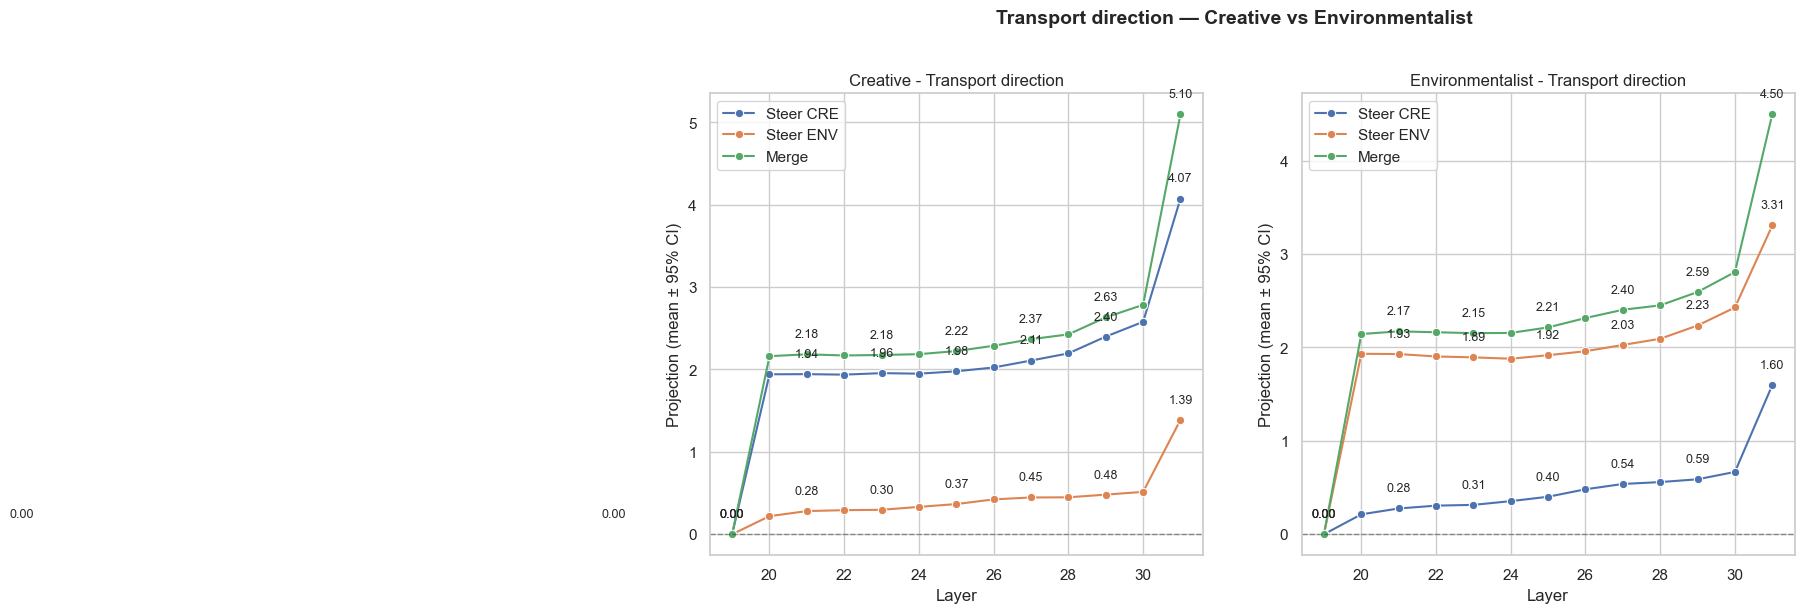

In [ ]:
# Cell 4c: Transport direction (Creative vs Environmentalist)

# ---- Plot 3: Transport direction ----
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

panels_transport = [
    ("Creative - Transport direction", famA["transport"]),
    ("Environmentalist - Transport direction", famB["transport"]),
]

for ax, (title, DF) in zip(axes, panels_transport):
    if DF is None or DF.empty:
        ax.set_visible(False)
        continue
    # line + CI
    sns.lineplot(data=DF, x="layer", y="mean", hue="series", marker="o", ci=None, ax=ax)
    for s in DF["series"].unique():
        sub = DF[DF["series"] == s]
        ax.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title)
    ax.set_xlabel("Layer")
    ax.set_ylabel("Projection (mean ± 95% CI)")
    ax.legend(title="", loc="best")
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=9)

plt.suptitle("Transport direction — Creative vs Environmentalist vs Merged", 
             y=1.02, fontsize=14, fontweight="bold")
plt.tight_layout()
plt.show()

### Fig B2 — Single-persona steering vs merged: transport axis
- (vec_cre/env use proj_transport; merged uses proj_A_transport/proj_B_transport)

In [69]:
# # Cell 5: Fig B2 – Transport projections across layers

# cre_tr = agg_mean_ci(df_cre,  "proj_transport").assign(series="Steer CRE: proj(transport)")
# env_tr = agg_mean_ci(df_env,  "proj_transport").assign(series="Steer ENV: proj(transport)")
# mA_tr  = agg_mean_ci(df_merge,"proj_A_transport").assign(series="Merge: proj(A_transport)")
# mB_tr  = agg_mean_ci(df_merge,"proj_B_transport").assign(series="Merge: proj(B_transport)")

# V_tr = pd.concat([cre_tr, env_tr, mA_tr, mB_tr], ignore_index=True)

# plt.figure(figsize=(8,5))
# sns.lineplot(data=V_tr, x="layer", y="mean", hue="series", ci=None)
# for s in V_tr["series"].unique():
#     sub = V_tr[V_tr["series"]==s]
#     plt.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)

# plt.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
# plt.title("Transport projections across layers (single vs merge)")
# plt.xlabel("Layer"); plt.ylabel("Projection (mean ± 95% CI)")
# plt.legend(title="", loc="best")
# plt.tight_layout(); plt.show()


In [70]:
# # Cell 5: Fig B2 – Transport projections across layers

# cre_tr = agg_mean_ci(df_cre,  "proj_transport").assign(series="Steer CRE: proj(transport)")
# env_tr = agg_mean_ci(df_env,  "proj_transport").assign(series="Steer ENV: proj(transport)")
# mA_tr  = agg_mean_ci(df_merge,"proj_A_transport").assign(series="Merge: proj(A_transport)")
# mB_tr  = agg_mean_ci(df_merge,"proj_B_transport").assign(series="Merge: proj(B_transport)")

# V_tr = pd.concat([cre_tr, env_tr, mA_tr, mB_tr], ignore_index=True)

# plt.figure(figsize=(8,5))
# sns.lineplot(data=V_tr, x="layer", y="mean", hue="series", ci=None)
# for s in V_tr["series"].unique():
#     sub = V_tr[V_tr["series"]==s]
#     plt.fill_between(sub["layer"], sub["mean"]-sub["ci"], sub["mean"]+sub["ci"], alpha=0.12)

# plt.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
# plt.title("Transport projections across layers (single vs merge)")
# plt.xlabel("Layer"); plt.ylabel("Projection (mean ± 95% CI)")
# plt.legend(title="", loc="best")
# annotate_every_two_layers(plt.gca(), step=2, fmt="{:.2f}", fontsize=8)
# force_axis_labels(plt.gca(), xlabel="Layer", ylabel="Projection (mean ± 95% CI)")

# plt.tight_layout(); plt.show()


### Fig C1 — All merged projections in one grid
- (6 lines: A20, B20, A_L, B_L, A_transport, B_transport; plus Δ L2)

/var/folders/09/1tps27xd5fx1ztnqbvpvp7l40000gn/T/ipykernel_31998/343007055.py:39: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


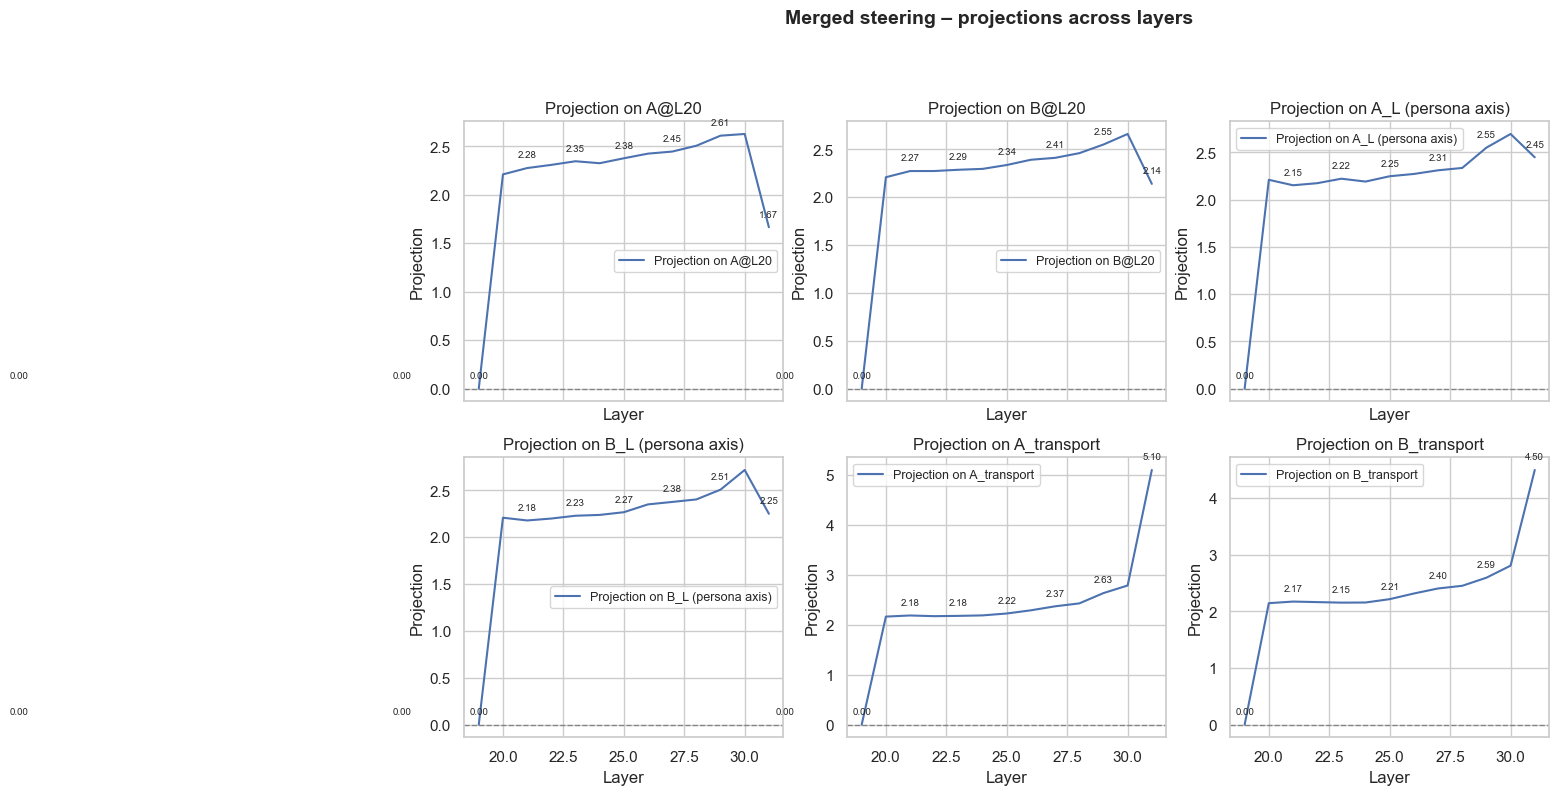

In [64]:
# Cell 6: Fig C1 – Vector merge gallery

metrics = [
    ("proj_A20", "Projection on A@L20"),
    ("proj_B20", "Projection on B@L20"),
    ("proj_A_L", "Projection on A_L (persona axis)"),
    ("proj_B_L", "Projection on B_L (persona axis)"),
    ("proj_A_transport", "Projection on A_transport"),
    ("proj_B_transport", "Projection on B_transport"),
]
delta_metric = ("delta_l2", "Delta magnitude ||Δh||")

# compute means/CI
curves = [(m, agg_mean_ci(df_merge, m).rename(columns={"mean":m+"_mean","ci":m+"_ci"})) for m,_ in metrics]
delta   = agg_mean_ci(df_merge, delta_metric[0]).rename(columns={"mean":delta_metric[0]+"_mean","ci":delta_metric[0]+"_ci"})

# merge on layer for convenience
merged = None
for m, dfc in curves + [(delta_metric[0], delta)]:
    merged = dfc if merged is None else pd.merge(merged, dfc, on="layer", how="outer")
merged = merged.sort_values("layer")

# plot grid
fig, axes = plt.subplots(2, 3, figsize=(14,8), sharex=True)
axes = axes.ravel()

for ax, (m, title) in zip(axes, metrics):
    y = merged[m+"_mean"]; ci = merged[m+"_ci"]; x = merged["layer"]
    ax.plot(x, y, label=title)
    ax.fill_between(x, y-ci, y+ci, alpha=0.12)
    ax.axhline(0, color="k", lw=1, ls="--", alpha=0.4)
    ax.set_title(title)
    force_axis_labels(ax, xlabel="Layer", ylabel="Projection")
    annotate_every_two_layers(ax, step=2, fmt="{:.2f}", fontsize=7)  # 子圖字小一點
    ax.legend(loc="best", fontsize=9)


fig.suptitle("Merged steering – projections across layers", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


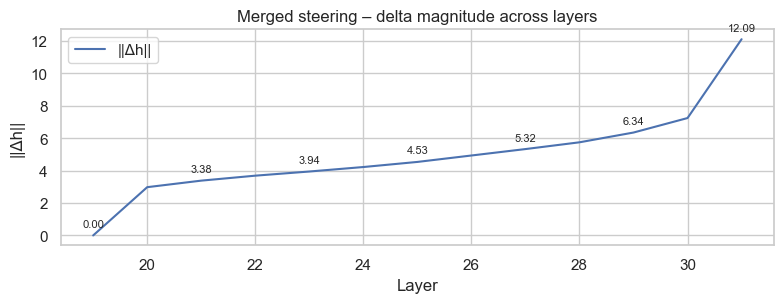

In [ ]:
# delta ||Δh|| as a separate strip (cleaner)
plt.figure(figsize=(8,3.2))
x = merged["layer"]; y = merged["delta_l2_mean"]; ci = merged["delta_l2_ci"]
plt.plot(x, y, label="||Δh||")
plt.fill_between(x, y-ci, y+ci, alpha=0.12)
plt.title("Merged steering – delta magnitude across layers")
plt.xlabel("Layer"); plt.ylabel("||Δh||")
annotate_every_two_layers(plt.gca(), step=2, fmt="{:.2f}", fontsize=8)
force_axis_labels(plt.gca(), xlabel="Layer", ylabel="||Δh||")
plt.legend(loc="best"); plt.tight_layout(); plt.show()


### (Optional but strong) Figure Set D — Additivity check & stability
- If you also want to (i) show linear additivity and (ii) compare variability across prompts:

In [43]:
# # Cell 7: Fig D1 – Additivity at final layer (A_L + B_L)
# FINAL_LAYER = 31  # if your model's last residual index is 31; set to 32 if needed

# # build predicted = single CRE (proj_vL) + single ENV (proj_vL), observed = merged (A_L + B_L)
# pred_df = pd.merge(
#     df_cre[df_cre["layer"]==FINAL_LAYER][["prompt_idx","proj_vL"]],
#     df_env[df_env["layer"]==FINAL_LAYER][["prompt_idx","proj_vL"]],
#     on="prompt_idx", suffixes=("_A","_B")
# )
# pred_df["pred_sum"] = pred_df["proj_vL_A"] + pred_df["proj_vL_B"]

# obs_df = df_merge[df_merge["layer"]==FINAL_LAYER][["prompt_idx","proj_A_L","proj_B_L"]].copy()
# obs_df["obs_sum"] = obs_df["proj_A_L"] + obs_df["proj_B_L"]

# both = pd.merge(pred_df[["prompt_idx","pred_sum"]], obs_df[["prompt_idx","obs_sum"]], on="prompt_idx")
# x = both["pred_sum"].values; y = both["obs_sum"].values

# plt.figure(figsize=(5.5,5))
# sns.scatterplot(x=x, y=y, s=50)
# mn, mx = min(x.min(), y.min()), max(x.max(), y.max())
# plt.plot([mn, mx], [mn, mx], "k--", alpha=0.6, label="y = x")
# # simple least-squares fit
# coef = np.polyfit(x, y, 1); fit = np.polyval(coef, np.sort(x))
# plt.plot(np.sort(x), fit, label=f"fit: y={coef[0]:.2f}x+{coef[1]:.2f}")
# # R^2
# ss_res = np.sum((y - np.polyval(coef, x))**2)
# ss_tot = np.sum((y - y.mean())**2) + 1e-8
# r2 = 1 - ss_res/ss_tot
# plt.title(f"Additivity at final layer (A_L + B_L), R²={r2:.2f}")
# plt.xlabel("Predicted A+B (single CRE + single ENV)")
# plt.ylabel("Observed A+B (merged)")
# plt.legend(); plt.tight_layout(); plt.show()


# # Cell 8: Fig D2 – Across-prompt stability (std vs layer)
# def layer_std(df, col):
#     g = df.groupby("layer")[col]
#     return g.std(ddof=1).reset_index(name="std")

# s_cre_tr = layer_std(df_cre,  "proj_transport").assign(series="Steer CRE: transport")
# s_env_tr = layer_std(df_env,  "proj_transport").assign(series="Steer ENV: transport")
# mA_tr_sd = layer_std(df_merge,"proj_A_transport").assign(series="Merge: A_transport")
# mB_tr_sd = layer_std(df_merge,"proj_B_transport").assign(series="Merge: B_transport")

# stab = pd.concat([s_cre_tr, s_env_tr, mA_tr_sd, mB_tr_sd], ignore_index=True)

# plt.figure(figsize=(8,5))
# sns.lineplot(data=stab, x="layer", y="std", hue="series", marker="o")
# plt.title("Across-prompt variability (Std) vs layer")
# plt.xlabel("Layer"); plt.ylabel("Std across prompts")
# plt.legend(title="", loc="best")
# annotate_every_two_layers(plt.gca(), step=2, fmt="{:.2f}", fontsize=8)
# force_axis_labels(plt.gca(), xlabel="Layer", ylabel="Std across prompts")

# plt.tight_layout(); plt.show()
